# ISOMAP

This question aims to reproduce the ISOMAP algorithm results in the original paper for
ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323
that we have also seen in the lecture as an exercise (isn’t this exciting to go through the
process of generating results for a high-impact research paper!)
The file isomap.mat (or isomap.dat) contains 698 images, corresponding to different poses
of the same face. Each image is given as a 64 × 64 luminosity map, hence represented as a
vector in R
4096. This vector is stored as a row in the file. [This is one of the datasets used in
the original paper] In this question, you are expected to implement the ISOMAP algorithm
by coding it up yourself. You may use the provided functions in ShortestPath.zip to find the
shortest path as required by one step of the algorithm. To load data in Python, for instance,
you can use from scipy.io import loadmat, images = loadmat(‘isomap.mat’)[‘images’]. To load
data in Matlab, you can directly use load() function.
Choose the Euclidean distance (i.e., in this case, a distance in R
4096) to construct the
nearest neighbor graph—vertices corresponding to the images. Construct a similarity graph
with vertices corresponding to the images, and tune the threshold  so that each node has
at least K = 50 neighbors (this approach corresponds to the so-called -Isomap).

**(a) (10 points) Visualize the similarity graph (you can either show the adjacency matrix,
or similar to the lecture slides, visualize the graph using graph visualization packages
such as Gephi (https://gephi.org) and illustrate a few images corresponds to nodes at
different parts of the graph, e.g., mark them by hand or use software packages).**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import BboxImage 
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
import pandas as pd
from sklearn.cluster import KMeans
from scipy.linalg import fractional_matrix_power
from scipy import sparse
from scipy.io import loadmat
from scipy.spatial.distance import cdist
import imageio
from skimage.transform import resize, rescale, downscale_local_mean
import sys
import os, glob
from math import ceil
from data.ShortestPath.Matrix_D import Matrix_D
import time

floatformat = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':floatformat})

In [2]:
images = loadmat('data/isomap.mat')['images']
images = images.T

###### First six faces from dataset

<Figure size 57600x57600 with 0 Axes>

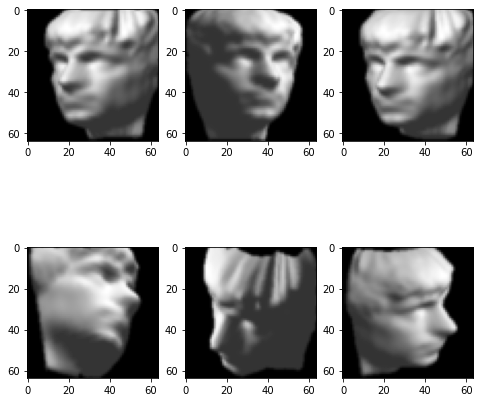

In [3]:
plt.figure(figsize = (800,800))
fig, axes = plt.subplots(nrows = 2, ncols=3, figsize = (8,8))
ax = axes.ravel()

for i, img in enumerate(images[0:6]):
    ax[i].imshow(np.reshape(img, (64, 64)).T, cmap='gray')

In [4]:
def tuneK(images, tunerangelist, minK):
    distances = cdist(images, images)
#     print(f" Distances: {distances}")
    minneighbors = []
    for x in tunerangelist:
        distances2  = np.array(distances)
        neighbors = []
        for row in distances2:
            row[row > x] = 0
            neighbors.append(len(row[row > 0]))
#             print(f"nonzero rows: {row[row > 0]}")
#         print(f"Neighbors for {x}: {neighbors} ")
        minneighbors.append(min(neighbors))
    minneighbors = np.array(minneighbors)
    print(f" Minimum neighbors for each item in tune range: {minneighbors}")
    minneighbors[minneighbors < 50] = minK*1000
    if np.min(minneighbors) > minK: 
        k = np.argmin(minneighbors)
    else:
        k = "None Found"
#         print(minneighbors)
    return k    

In [5]:
tuneK(images, range(20,25), 50)

 Minimum neighbors for each item in tune range: [ 46  57  84 134 157]


1

In [6]:
################
### K-ISOMAP ###
################

# distances = cdist(images, images)

# k = 50
# for x in distances:
#     top = np.argsort(x, 0)
#     x[top[k+1:]] = 0

In [7]:
################
### E-ISOMAP ###
################

distances = cdist(images, images)

e = 21
for x in distances:
    x[x > e] = 0

adj = np.array(distances)

In [8]:
# distances[0][distances[0] > 0]

In [9]:
start = time.time()
G = nx.from_numpy_matrix(distances, create_using = nx.DiGraph)
# nx.set_node_attributes(G, newnodelabels, "label")
# nx.set_node_attributes(G, newnodeinds, "index")

# G.nodes(data=True)
# max(G.nodes)
pos = nx.spring_layout(G)

print(f"G building took {time.time() - start} seconds")


G building took 8.480928897857666 seconds


###### Graphing

The below is the graph of the similarity matrix. The first 10 nodes are labeled with a thumbnail of the image they represent.

plotting took 655.0971744060516 seconds


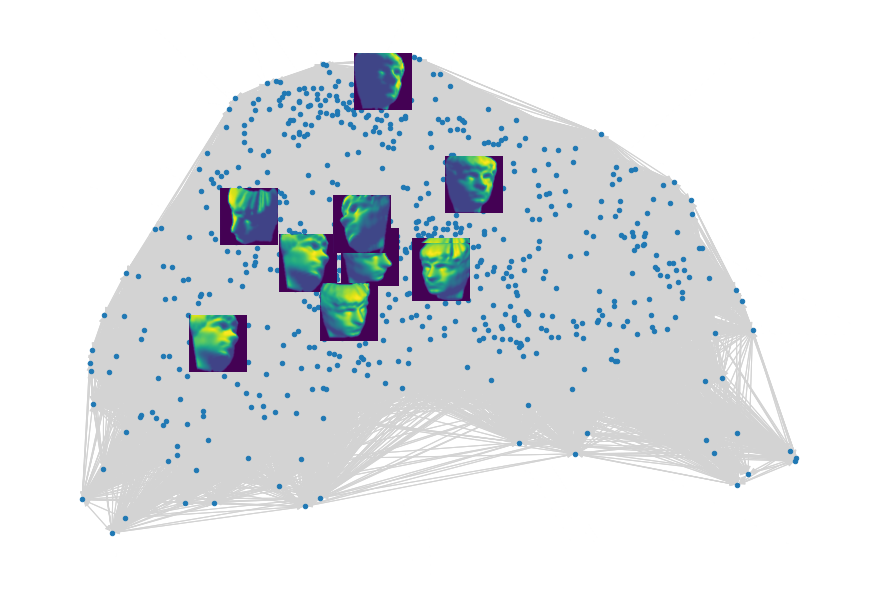

In [10]:
start = time.time()
plt.figure(figsize=(12,8))
# nx.draw(G, alpha=0.3, node_size = 20, node_color=[x[1]['label'] for x in G.nodes(data=True)], edge_color = "lightgrey", cmap = plt.cm.Set3)
nx.draw(G, pos, node_size = 20, edge_color = "lightgrey") #, cmap = plt.cm.Set3, alpha=0.3)
ax=plt.gca()
fig=plt.gcf()
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.1 # this is the image size
counter = 0
for n in G.nodes():
    if counter < 10:
        (x,y) = pos[n]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize])
        a.imshow(np.reshape(images[n], (64, 64)).T)
        a.set_aspect('equal')
        a.axis('off')
        counter += 1
print(f"plotting took {time.time() - start} seconds")
plt.show()

**(b) (20 points) Implement the ISOMAP algorithm yourself to obtain a two-dimensional
low-dimensional embedding. Plot the embeddings using a scatter plot, similar to the
plots in lecture slides. Find a few images in the embedding space and show what these
images look like. Comment on do you see any visual similarity among them and their
arrangement, similar to what you seen in the paper?**

In [11]:
def modD(W, Graph):  
    n = np.shape(W)[0]
    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    np.savetxt('D.csv', D)
    return D

In [12]:
start = time.time()
D = modD(distances, G)
print(f"file took {time.time() - start} seconds")



file took 129.51741647720337 seconds


In [13]:
m = D.shape[0]
H = np.identity(m) - ( (1/m) *  np.ones((m,m)) )
H

array([[0.999, -0.001, -0.001, ..., -0.001, -0.001, -0.001],
       [-0.001, 0.999, -0.001, ..., -0.001, -0.001, -0.001],
       [-0.001, -0.001, 0.999, ..., -0.001, -0.001, -0.001],
       ...,
       [-0.001, -0.001, -0.001, ..., 0.999, -0.001, -0.001],
       [-0.001, -0.001, -0.001, ..., -0.001, 0.999, -0.001],
       [-0.001, -0.001, -0.001, ..., -0.001, -0.001, 0.999]])

In [14]:
C = (-1/2) * (H@np.square(D)@H)
C


array([[98.530, -47.462, 87.705, ..., -86.773, -179.248, 22.719],
       [-47.462, 161.151, -49.410, ..., 120.353, -33.984, -3.273],
       [87.705, -49.410, 122.352, ..., -157.615, -177.969, 22.732],
       ...,
       [-86.773, 120.353, -157.615, ..., 306.791, -78.470, 141.665],
       [-179.248, -33.984, -177.969, ..., -78.470, 479.295, 169.434],
       [22.719, -3.273, 22.732, ..., 141.665, 169.434, 272.212]])

In [15]:
vecs, vals, _ = np.linalg.svd(C)
vecs.shape

dims = 2
Z = vals[:dims] * vecs[:,:dims]
Z.shape

(698, 2)

###### ISOMAP

Below, we plot the projection of the images on to 2 dimensions. We've also shown a few semi-random faces from the dataset. 

There's a couple good signs here:
1. We see the scatterplot take a shape nearly identical to the scatterplot shown in the lecture slides, ith a sort of crescent shape
2. We see the faces are very tightly organized, with points on the left looking left, points on the right facing right, and likewise with the top and bottom. 

The epsilon in this case is 21.

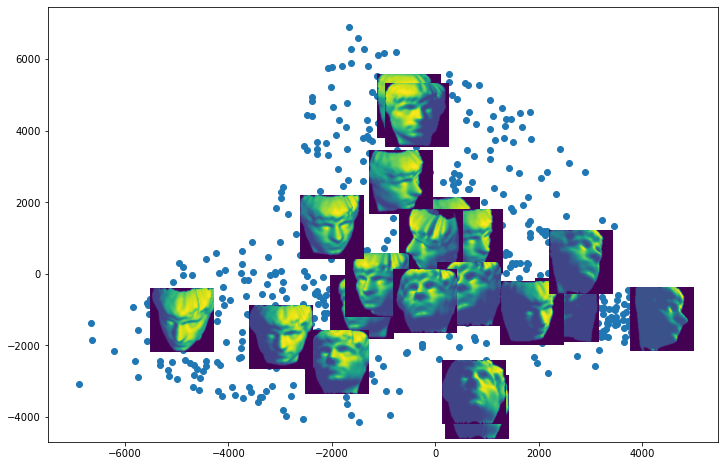

In [16]:
plt.figure(figsize=(12,8))
ax=plt.gca()
fig=plt.gcf()
fig.canvas.draw
plt.plot(Z[:,0], Z[:,1], linestyle='none', marker='o')

for i in range(0,100,5):
    image = np.reshape(images[i], (64, 64)).T
    imagebox = OffsetImage(image, zoom=1)
    
    xy = [Z[i,0], Z[i,1]]
    ab = AnnotationBbox(imagebox, xy, frameon=False) 
    
    ax.add_artist(ab)  
        
plt.show()


### Manhattan Distance (c)

**(c) (10 points) Now choose 1 distance (or Manhattan distance) between images (recall the definition from “Clustering” lecture)). Repeat the steps above. Use -ISOMAP to obtain a k = 2 dimensional embedding. Present a plot of this embedding. Do you see any difference by choosing a different similarity measure by comparing results in Part
(b) and Part (c)?**

In [17]:
def tuneKman(images, tunerangelist, minK):
    distances = cdist(images, images, metric = 'cityblock') #make manhattan
#     print(f" Distances: {distances}")
    minneighbors = []
    for x in tunerangelist:
        distances2  = np.array(distances)
        neighbors = []
        for row in distances2:
            row[row > x] = 0
            neighbors.append(len(row[row > 0]))
#             print(f"nonzero rows: {row[row > 0]}")
#         print(f"Neighbors for {x}: {neighbors} ")
        minneighbors.append(min(neighbors))
    minneighbors = np.array(minneighbors)
    print(f" Minimum neighbors for each item in tune range: {minneighbors}")
    minneighbors[minneighbors < 50] = minK*1000
    if np.min(minneighbors) >= minK: 
        k = np.argmin(minneighbors)
    else:
        k = "None Found"
#         print(minneighbors)
    return k    

In [18]:
tuneKman(images, range(900, 925, 2), 50)

 Minimum neighbors for each item in tune range: [48 49 50 50 52 52 53 53 53 54 54 57 57]


2

In [19]:
################
### E-ISOMAP ###
################

distances = cdist(images, images, metric = 'cityblock') # make manhattan

e = 902
for x in distances:
    x[x > e] = 0

adj = np.array(distances)

In [20]:
# distances

In [21]:
start = time.time()
G = nx.from_numpy_matrix(distances, create_using = nx.DiGraph)
# nx.set_node_attributes(G, newnodelabels, "label")
# nx.set_node_attributes(G, newnodeinds, "index")

# G.nodes(data=True)
# max(G.nodes)
pos = nx.spring_layout(G)

print(f"G building took {time.time() - start} seconds")


G building took 9.979119539260864 seconds


In [ ]:
start = time.time()
plt.figure(figsize=(12,8))
# nx.draw(G, alpha=0.3, node_size = 20, node_color=[x[1]['label'] for x in G.nodes(data=True)], edge_color = "lightgrey", cmap = plt.cm.Set3)
nx.draw(G, pos, node_size = 20, edge_color = "lightgrey") #, cmap = plt.cm.Set3, alpha=0.3)
ax=plt.gca()
fig=plt.gcf()
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.1 # this is the image size
counter = 0
for n in G.nodes():
    if counter < 10:
        (x,y) = pos[n]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize])
        a.imshow(np.reshape(images[n], (64, 64)).T)
        a.set_aspect('equal')
        a.axis('off')
        counter += 1
print(f"plotting took {time.time() - start} seconds")
plt.show()

In [ ]:
start = time.time()
D = modD(distances, G)
print(f"file took {time.time() - start} seconds")
D


In [ ]:
m = D.shape[0]
H = np.identity(m) - ( (1/m) *  np.ones((m,m)) )
H

In [ ]:
C = (-1/2) * (H@np.square(D)@H)
C


In [ ]:
vecs, vals, _ = np.linalg.svd(C)
vecs.shape

dims = 2
Z = vals[:dims] * vecs[:,:dims]
Z.shape

###### Manhattan ISOMAP

Based on the points plotted, the Manhattan distance does not seem to work nearly as well on this dataset. Manhattan distance is less direct, and we've not real reason to use manhattan distance for this problem (that I know of). For some reason, the manhattan distance seems to be keying in on the brightness of images moreso than the orientation of the face, unlike the euclidian distance. Nonetheless, it is still fair to say that the images are more organized now than they were in the simple similarity matrix. We will soon see, however, that this distance function doesn't necesarily outperform PCA by too much (to the naked eye, at least).

In [ ]:
plt.figure(figsize=(12,8))
ax=plt.gca()
fig=plt.gcf()
fig.canvas.draw
plt.plot(Z[:,0], Z[:,1], linestyle='none', marker='o')

for i in range(0,100,5):
    image = np.reshape(images[i], (64, 64)).T
    imagebox = OffsetImage(image, zoom=1)
    
    xy = [Z[i,0], Z[i,1]]
    ab = AnnotationBbox(imagebox, xy, frameon=False) 
    
    ax.add_artist(ab)  
        
plt.show()


**(d) (10 points) Perform PCA (you can now use your implementation written in Question 1) on the images and project them into the top 2 principal components. Again show
them on a scatter plot. Explain whether or you see a more meaningful projection using
ISOMAP than PCA.**

In [ ]:
vecs2, vals2, _ = np.linalg.svd(images)
vecs2.shape

dims2 = 2
Z2 = vals2[:dims2] * vecs2[:,:dims2]
Z2.shape

###### PCA

The simple PCA picks up on the similarities in color and shading, but not as much the shape of the faces. It has organized the data better than it was before, but is much less effective than the Euclidian ISOMAP.

In [ ]:
plt.figure(figsize=(12,8))
ax=plt.gca()
fig=plt.gcf()
fig.canvas.draw
plt.plot(Z2[:,0], Z2[:,1], linestyle='none', marker='o')

for i in range(0,100,5):
    image = np.reshape(images[i], (64, 64)).T
    imagebox = OffsetImage(image, zoom=1)
    
    xy = [Z2[i,0], Z2[i,1]]
    ab = AnnotationBbox(imagebox, xy, frameon=False) 
    
    ax.add_artist(ab)  
        
plt.show()

# Density Estimation

We will use this data to study whether or not the two brain regions are likely to be independent of each other and considering different types of political view For this question; you
can use the proper package for histogram and KDE; no need to write your own.
The data set n90pol.csv contains information on 90 university students who participated in
a psychological experiment designed to look for relationships between the size of different
regions of the brain and political views. The variables amygdala and acc indicate the volume
of two particular brain regions known to be involved in emotions and decision-making, the
amygdala and the anterior cingulate cortex; more exactly, these are residuals from the predicted volume, after adjusting for height, sex, and similar body-type variables. The variable
orientation gives the students’ locations on a five-point scale from 1 (very conservative) to 5
(very liberal). Note that in the dataset, we only have observations for orientation from 2 to
5.
Recall in this case, the kernel density estimator (KDE) for a density is given by
p(x) = 1
m
Xm
i=1
1
h
K

x
i − x
h

,
where x
i are two-dimensional vectors, h > 0 is the kernel bandwidth, based on the criterion
we discussed in lecture. For one-dimensional KDE, use a one-dimensional Gaussian kernel
K(x) = 1
√
2π
e
−x
2/2
.
For two-dimensional KDE, use a two-dimensional Gaussian kernel: for
x =

x1
x2

∈ R
2
,
where x1 and x2 are the two dimensions respectively
K(x) = 1
2π
e
−
(x1)
2+(x2)
2
2 .

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import time
import seaborn as sns
from scipy.stats import gaussian_kde

In [ ]:
data = pd.read_csv('data/n90pol.csv')
data.head()

###### Part 1

(a) (10 points) Form the 1-dimensional histogram and KDE to estimate the distributions
of amygdala and acc, respectively. For this question, you can ignore the variable orientation. Decide on a suitable number of bins so you can see the shape of the distribution
2
clearly. Set an appropriate kernel bandwidth h > 0. For example. for one-dimensional
KDE, you are welcome to use a rule-of-thumb bandwidth estimator
h ≈ 1.06ˆσn−1/5
,
where n is the sample size, ˆσ is the standard error of samples; this is shown to be
optimal when Gaussian kernel functions are used for univariate data.

In [ ]:
sigma = np.std(data['amygdala'])
n = len(data['amygdala'])
h = (n**(-1/5)) * sigma * 1.06
h

In [ ]:
sns.displot(data['amygdala'], kde = True, stat = 'probability', rug = True, binwidth = h) #bw_adjust = .7)

In [ ]:
sns.kdeplot(data['amygdala'], bw_adjust = .7)

We used *h* for the bin width. The default bandwidth of the package is good--but we've also shown a slightly more contoured KDE as well in the second image.

###### Part 2

(b) (10 points) Form 2-dimensional histogram for the pairs of variables (amygdala, acc).
Decide on a suitable number of bins so you can see the shape of the distribution clearly

In [ ]:
plt.hist2d(data['amygdala'], data['acc'], bins = (10,10))
plt.colorbar()
plt.show

sns.jointplot(data=data, x=data['amygdala'], y=data['acc'], kind="hist", cbar = True, bins = (10,10))

Done two different ways for fun.

###### Part 3

(c) (10 points) Use kernel-density-estimation (KDE) to estimate the 2-dimensional density
function of (amygdala, acc) (this means for this question, you can ignore the variable
orientation). Set an appropriate kernel bandwidth h > 0.
Please show the two-dimensional KDE (e.g., two-dimensional heat-map, two-dimensional
contour plot, etc.)
Please explain based on the results, can you infer that the two variables (amygdala,
acc) are likely to be independent or not?

In [ ]:
sns.kdeplot(data=data, x="amygdala")
sns.kdeplot(data=data, x="acc", color = "orange")

In [ ]:
sns.jointplot(x=np.random.normal(size=50), y=np.random.normal(size=50), kind="kde", fill=True)

In [ ]:
sns.jointplot(data=data, x=data['amygdala'], y=data['acc'], kind="kde", fill=True)

In [ ]:
m1 = data['amygdala']
m2 = data['acc']

xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

kde1 = gaussian_kde(m1)
kde2 = gaussian_kde(m2)

xs = np.array([kde1.evaluate(i) for i in data['amygdala']])
ys = np.array([kde2.evaluate(i) for i in data['acc']])

X, Y = np.mgrid[xmin:xmax:90j, ymin:ymax:90j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = gaussian_kde(values)

xys = np.array([kernel.evaluate((m1[i], m2[i])) for i in range(0, len(values[0]))])
xtimesys = np.multiply(xs, ys)
Z = np.reshape(kernel(positions).T, X.shape)



# pdf1 = pd.DataFrame(xs)
# pdf2 = pd.DataFrame(ys)
# combo = pd.DataFrame([both.evaluate(i) for i in data['acc']])

# joint = pd.DataFrame(pdf1[0]*pdf2[0])

# sns.kdeplot(x = pdf1[0])
# sns.kdeplot(x = pdf2[0])
# sns.jointplot(x = comb[0], y = comb[1], kind = 'kde', fill=True)

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
#           extent=[xmin, xmax, ymin, ymax])
# # ax.plot(m1, m2, 'k.', markersize=2)
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])
# plt.show()

# print(xtimesys)
# print(xys)
# print(m1[0:5])
# print(m2[0:5])

sns.scatterplot(x = [i[0] for i in xys], y = [i[0] for i in xtimesys])


Above we show the two independent KDEs, and then the 2 dimensional combined KDE. Given that the KDE has no specific shape, it looks like these two variables are nearly independent. 

To doubel check, we then do the actual math--we find the P(X) and P(Y), as well as P(X, Y), and then we plot P(X, Y) vs P(X)P(Y). If the varibales were entirely independent, then P(X, Y) would equal P(X)P(Y), meaning a straight diagonal line. So with this method we see that the variables are not independent entirely, but the points fall close to the line which emans they are nearly independent. 

Below we triple check by using the familair calculation of correlation (pearson's r), which shows a weak negative correlation of -0.13.

In [ ]:
print(f"Correlation between amygdala and acc: {data['amygdala'].corr(data['acc'])}")
sns.jointplot(data=data, x=data['amygdala'], y=data['acc'], kind="reg")

###### Part 4

(d) (10 points) We will consider the variable orientation and consider conditional distributions. Please plot the estimated conditional distribution of amygdala conditioning
on political orientation: p(amygdala|orientation = c), c = 2, . . . , 5, using KDE. Set an
appropriate kernel bandwidth h > 0. Do the same for the volume of the acc: plot
p(acc|orientation = c), c = 2, . . . , 5 using KDE. (Note that the conditional distribution
can be understood as fitting a distribution for the data with the same orientation. Thus
you should plot 8 one-dimensional distribution functions in total for this question.)
Now please explain based on the results, can you infer that the conditional distribution
of amygdala and acc, respectively, are different from c = 2, . . . , 5? This is a type of
scientific question one could infer from the data: Whether or not there is a difference
between brain structure and political view.
Now please also fill out the conditional sample mean for the two variables:
c = 2 c = 3 c = 4 c = 5
amygdala
acc
Remark: As you can see this exercise, you can extract so much more information from
density estimation than simple summary statistics (e.g., the sample mean) in terms of
explorable data analysis.


In [ ]:
 for c in sorted(set(data['orientation'].values)):
    samp1 = data['amygdala'][data['orientation'] == c]
    samp2 = data['acc'][data['orientation'] == c]
    sigma1 = np.std(samp1)
    n1 = len(samp1)
    h1 = (n**(-1/5)) * sigma * 1.06
    sigma2 = np.std(samp2)
    n2 = len(samp2)
    h2 = (n**(-1/5)) * sigma * 1.06
    sns.displot(samp1, kde = True, stat = 'probability', rug = True, binwidth = h1
               ).set(title = f"c = {c} for Amygdala")
    sns.displot(samp2, kde = True, stat = 'probability', rug = True, binwidth = h2, color = "orange"
               ).set(title = f"c = {c} for Acc") 


From the individual kDE plots and the joint plots for each C, we can see that the distribution of amygdala and acc are different depending on orientation. I would caution that sample sizes at some C's are very small--however, with this intial data the researchers would be optimistic about the affect of Amygdala and Acc on Orientation.

Below is the table of means, which is much less informative than the KDE plots.

In [ ]:
frame = [['amygdala'],['acc']]
for c in range(2,6):
    frame[0].append(data['amygdala'][data['orientation'] == c].mean())
    frame[1].append(data['acc'][data['orientation'] == c].mean())
    
means = pd.DataFrame(frame, columns = ["variable", "c=2", "c=3", "c=4", "c=5"])
means


###### Part 5

(e) (10 points) Again we will consider the variable orientation. We will estimate the conditional joint distribution of the volume of the amygdala and acc, conditioning on a
function of political orientation: p(amygdala, acc|orientation = c), c = 2, . . . , 5. You
3
will use two-dimensional KDE to achieve the goal; et an appropriate kernel bandwidth h > 0. Please show the two-dimensional KDE (e.g., two-dimensional heat-map,
two-dimensional contour plot, etc.).
Please explain based on the results, can you infer that the conditional distribution of
two variables (amygdala, acc) are different from c = 2, . . . , 5? This is a type of scientific
question one could infer from the data: Whether or not there is a difference between
brain structure and political view.


In [ ]:
colorcounter = 0
for c in sorted(set(data['orientation'].values)):
    sns.jointplot(data=data, x=data['amygdala'][data['orientation'] == c], y=data['acc'][data['orientation'] == c], kind="kde",
                  color = sns.color_palette("Set3")[colorcounter]).fig.suptitle(f"c = {c} for Amygdala + Acc")
    #plt.title(f"c = {c} for Amygdala + Acc")
    colorcounter += 1

In [ ]:
sns.jointplot(data=data, x=data['amygdala'], y=data['acc'], hue="orientation", kind="kde", palette = "Set3")

In this case, we can infer that the conditional joint distributions are different depending on orientation. The KDE's have very different shapes, and it is possible that there might even be a stronger dependency between the variables where orientation = 5.